# Boilerplate

In [1]:
import bayesian_multitarget_latent_factors as bmlf
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

rng = np.random.default_rng(16180339)

In [2]:
def plot_all_B_dict(B_dict, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(13,8))
    else:
        fig = ax.get_figure()
    for i in range(B_dict['p']):
        bmlf.plot_col_basis_dict(B_dict, col_idx=i, ax=ax)
    ax.get_legend().set_visible(False)
    ax.set_title('')
    return fig, ax

## Fetch the Dataset

We use dataset `Biscuit` from the R package fds

The experiment involved varying the composition of biscuit dough pieces. Two sets of dough
pieces were measured, a calibration set and a prediction set. They were created and measured as
two distinct sets, on separate occasions, and do not result from a random (or any other) split of a
larger set.

The data labc (c stands for calibration) and labp (p stands for prediction) contain the reference
data on the composition of the doughs.
The data nirc and nirp contain 700 point near infrared reflectance (NIR) spectra for the same
dough. The spectral range is 1100-2498 nm in steps of 2nm.
The data labc$y is 4 rows by 40 columns, the rows being fat, sucrose, flour and water all in percents.
The percents do not quite add up to 100, since there are other minor ingredients present, but they
add up to nearly 100 percent.
According to Brown et al. (2001), the observation 23 in the calibration set appears as an outlier.
Sample number 21 in the labp shows up as a validation set.

In [3]:
from skfda.datasets import fetch_cran

while True:
    try:
        labp_R = fetch_cran('labp','fds')['labp']
        features = labp_R.dim_0.values
        Y2_test = labp_R.values
        labc_R = fetch_cran('labc','fds')['labc']
        features = labc_R.dim_0.values
        Y2 = labc_R.values
        nirp_R = fetch_cran('nirp','fds')['nirp']
        x = nirp_R['x']
        Y1_test = nirp_R['y'].values
        nirc_R = fetch_cran('nirc','fds')['nirc']
        Y1 = nirc_R['y'].values
        break
    except:
        continue

features

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warn

array(['Fat', 'Sucrose', 'Flour', 'Water'], dtype='<U7')

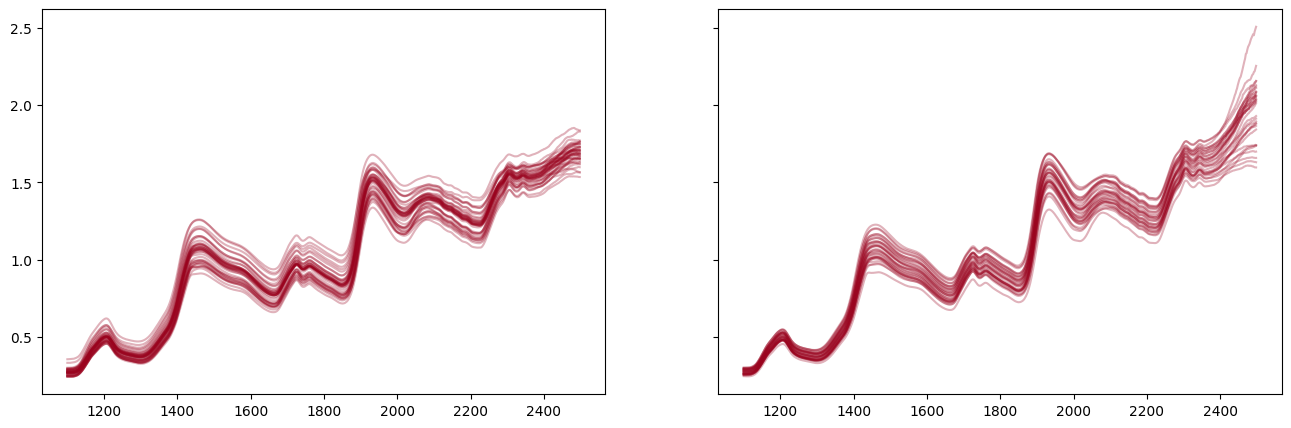

In [4]:
fig, axs = plt.subplots(1,2,figsize=(16,5), sharey=True)
_ = axs[0].plot(x, Y1, c=bmlf.default_color_dict['Carmine'], alpha=0.3)
_ = axs[1].plot(x, Y1_test, c=bmlf.default_color_dict['Carmine'], alpha=0.3)

## Center and Downsample

In [5]:
M1 = Y1.mean(axis=1)
Y1 = Y1 - M1[:,None]
Y1_test = Y1_test - M1[:,None]

In [6]:
x = x[::3]
Y1 = Y1[::3,:]
Y1_test = Y1_test[::3,:]

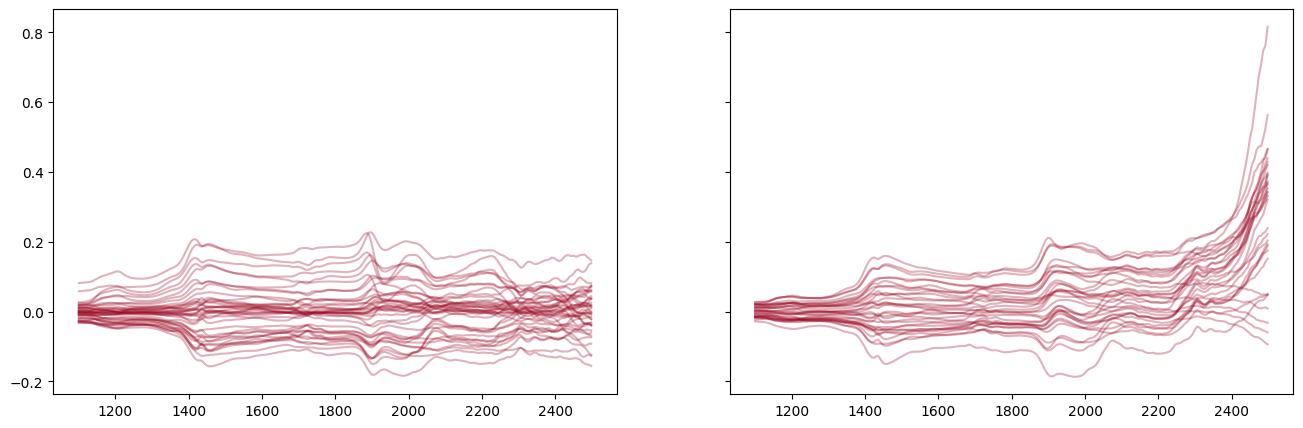

In [7]:
fig, axs = plt.subplots(1,2,figsize=(16,5), sharey=True)
_ = axs[0].plot(x, Y1, c=bmlf.default_color_dict['Carmine'], alpha=0.3)
_ = axs[1].plot(x, Y1_test, c=bmlf.default_color_dict['Carmine'], alpha=0.3)

In [8]:
M2 = Y2.mean(axis=1)
Y2 = Y2 - M2[:,None]
Y2_test = Y2_test - M2[:,None]

# Prior Selection

## Use PCA to create Basis Matrix for lab results target

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=3)
pca.fit(Y2.T)
[f'{val*100:.4}%' for val in pca.explained_variance_ratio_]

['82.22%', '17.24%', '0.5423%']

In [11]:
B2 = {
    'B': pca.components_.T,
    't': np.arange(4),
    'L': 4,
    'p': 3,
}

In [12]:
np.std(Y2,axis=1)

array([1.93438983, 3.86253608, 2.79547845, 1.57997911])

## Basis Function Selection

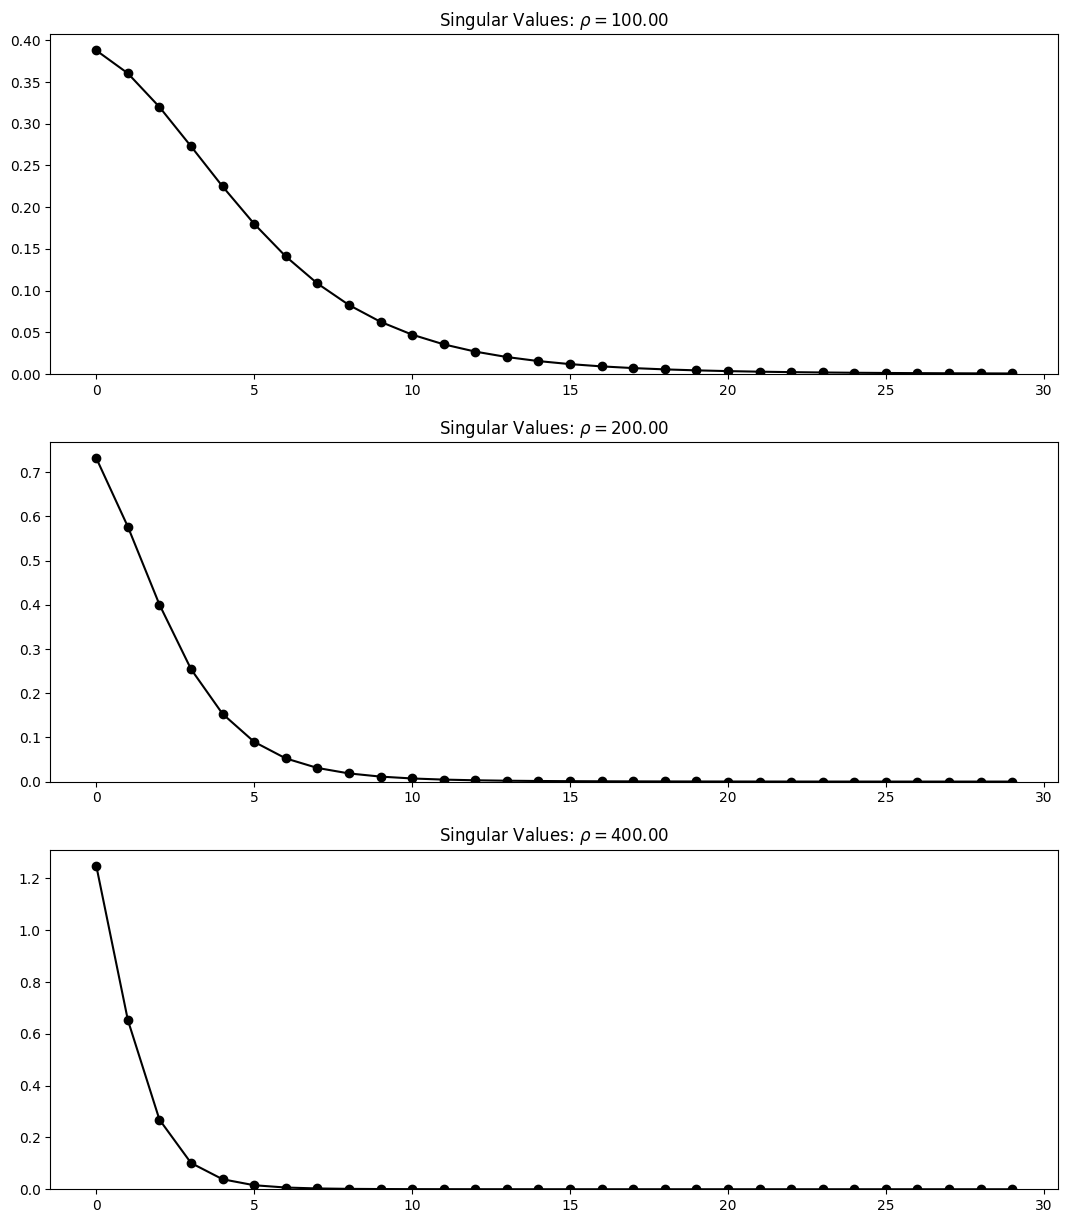

In [13]:
rho_list = [100,200,400]
sigma = 0.1
fig, axs = plt.subplots(3,1,figsize=(13,15))

for i in range(len(rho_list)):
    B = bmlf.build_matrix_B_from_gaussian_process_covariance(
        x,
        rho_list[i],
        num_singular_values=30,
        type_cov='matern_5_2',
        sigma=sigma,
    )
    U = bmlf.build_matrix_B_from_gaussian_process_covariance(
        x,
        rho_list[i],
        num_singular_values=30,
        type_cov='matern_5_2',
        use_S=False,
        sigma=sigma
    )
    S = np.square( np.diag(U['B'].T@B['B']) )
    axs[i].plot(S, 'ko-')
    axs[i].set_title('Singular Values: ' + r'$\rho = ' + f'{rho_list[i]:.2f}' + '$')
    axs[i].set_ylim(bottom=0.0)

(<Figure size 1300x800 with 1 Axes>, <Axes: xlabel='X Axis', ylabel='Value'>)

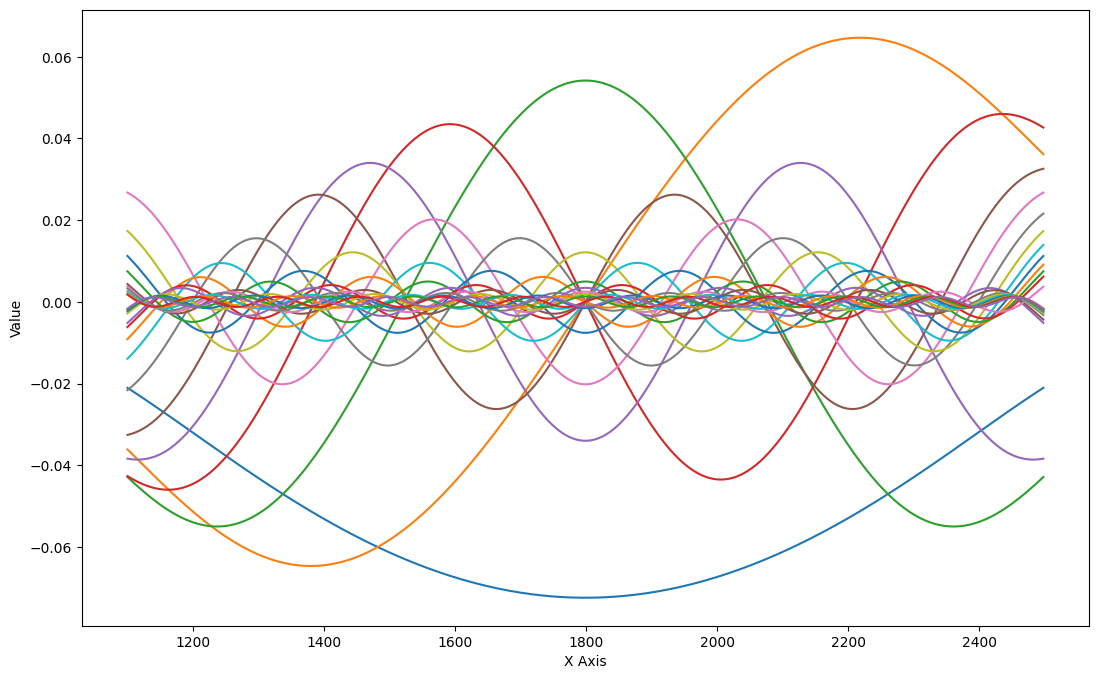

In [14]:
B1 = bmlf.build_matrix_B_from_gaussian_process_covariance(
    x,
    200,
    num_singular_values=25,
    sigma=0.1,
    nugget=0.0001,
    type_cov='matern_5_2',
    use_S=True,
)
plot_all_B_dict(B1)

## Select the Prior

In [15]:
hyperparams_dict = \
bmlf.initialize_hyperparams_dict(
    k=4,
    v=8,
    nu=100,
    ψ_alpha=5,
    ψ_beta=4,
    ψ_sigma_1=0.04,
    ψ_sigma_2=1e-6,
    θ_alpha=5,
    θ_beta=4,
    θ_sigma_1=0.3,
    θ_sigma_2=1.0,
    alpha_1=2.1,
    alpha_2=2.5,
)

In [16]:
prior_dict = bmlf.make_prior_dict(
    hyperparams_dict,
    B1,
    B2,
    y1 = Y1,
    y2 = Y2,
    X = np.zeros((1, Y2.shape[1]))
)

Warning! This computation assumes same β parameter for θs... computing beta_sigma as the average of the two.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

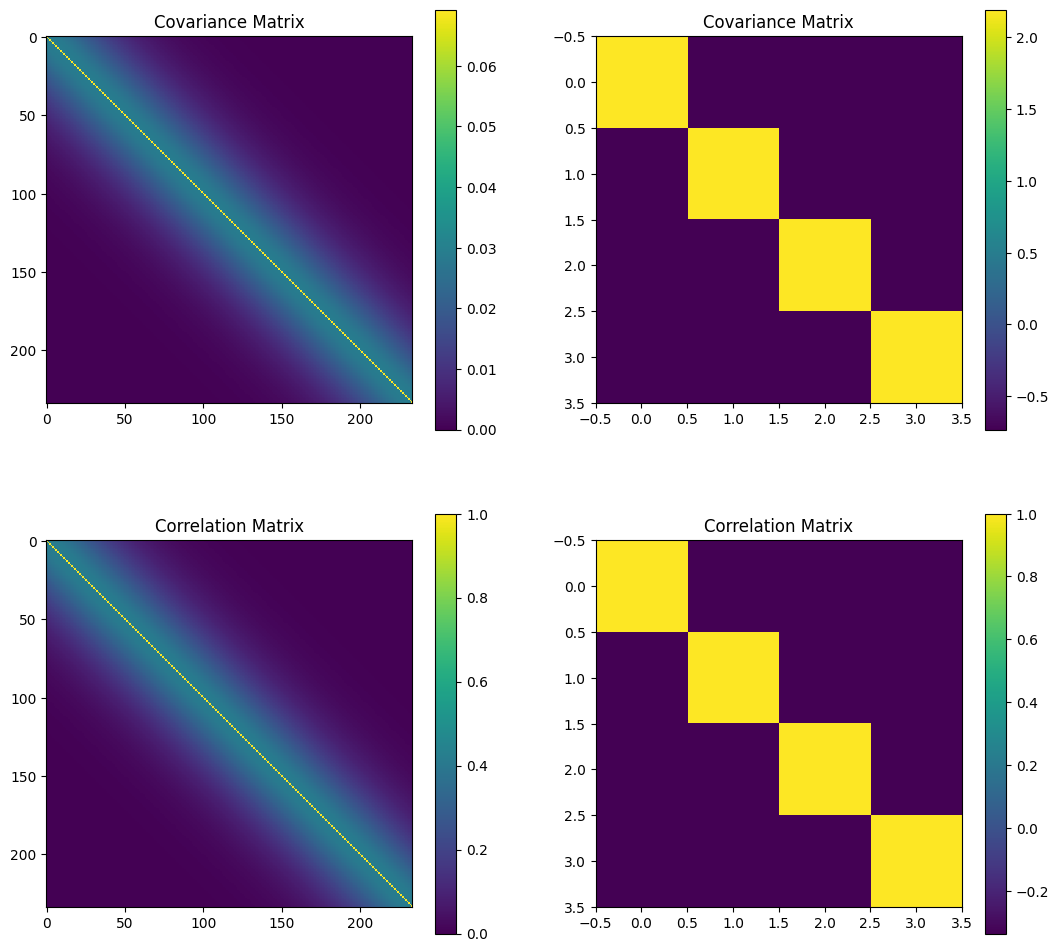

In [17]:
bmlf.prior_predictive_properties_from_prior_dict( prior_dict )

# Posterior Sampling

In [18]:
out_dir = './bisquit_calibration_posterior'

In [19]:
from os.path import isfile

if not isfile(out_dir + '/idata.nc'):
    idata = \
    bmlf.sample_from_posterior_moore_penrose_trick(
        prior_dict,
        rng.integers(1000000),
        stan_file_path=None,
        output_dir=out_dir,
        laplace_draws=100,
        iter_warmup=500,
        iter_sampling=500,
        do_prior_sampling=False,
        max_treedepth=12,
        X_test=None,
    )
    idata.to_netcdf(out_dir + '/idata.nc')
else:
    idata = az.from_netcdf(out_dir + '/idata.nc')

# Exploration of Posterior Distribution

## Varimax

In [20]:
Varimax_res_xr = bmlf.Varimax_RSP(idata)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		35818.514
Starting iteration number 1
	 Previous objective fun =	35818.514
	 New objective fun =		3454.228
Starting iteration number 2


## Compute $\widehat{K}$ and show outliers

In [21]:
loo_res = az.loo(idata)
dict_loo_res = dict(loo_res)
def transform_array(arr, thresholds):
    """
    Transform a numpy array of floats to a numpy array of ints based on the given thresholds.

    Parameters:
    - arr: numpy array of floats.
    - thresholds: list of thresholds defining the ranges for transformation.

    Returns:
    - A numpy array of ints where each element is transformed based on the thresholds.
    """
    # Create an output array filled with zeros, initially assuming all values fall into the first category.
    out = np.zeros(arr.shape, dtype=int)
    
    # Iterate over the thresholds, assigning an increasing integer value
    # for each range defined by these thresholds.
    for i, threshold in enumerate(thresholds):
        out[arr > threshold] = i + 1

    return out
thresholds = [0.5, 0.7, 1.0]
class_pareto_k = transform_array( dict_loo_res['pareto_k'].values , thresholds )

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Text(0, 0.5, '$\\eta_3$')

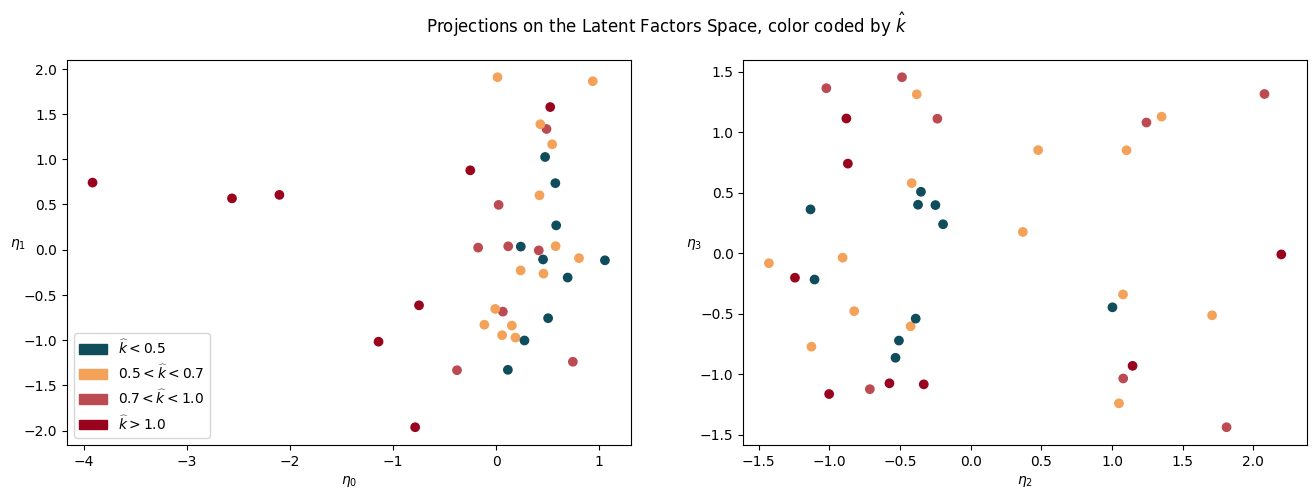

In [22]:
η_train_xr = \
bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr)
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1,2,figsize=(16,5))

col_seq = ['Midnight green', 'Sandy brown', 'Bittersweet shimmer', 'Carmine']
class_labels = ['Good', 'Ok', 'Bad', 'Very Bad']
class_labels = [r'$\widehat{k} < 0.5$', r'$0.5 < \widehat{k} < 0.7$', r'$0.7 < \widehat{k} < 1.0$', r'$\widehat{k} > 1.0$']

ax[0].scatter(η_train_xr.mean('chain').mean('draw').values.T[:,0],
              η_train_xr.mean('chain').mean('draw').values.T[:,1], c=[bmlf.default_color_dict[col_seq[i]] for i in class_pareto_k])
ax[1].scatter(η_train_xr.mean('chain').mean('draw').values.T[:,2],
              η_train_xr.mean('chain').mean('draw').values.T[:,3], c=[bmlf.default_color_dict[col_seq[i]] for i in class_pareto_k])

legend_patches = [mpatches.Patch(color=bmlf.default_color_dict[col_seq[i]], label=class_labels[i]) for i in range(len(col_seq))]
ax[0].legend(handles=legend_patches, loc='lower left')

fig.suptitle(r'Projections on the Latent Factors Space, color coded by $\hat{k}$')
ax[0].set_xlabel(r'$\eta_0$')
ax[0].set_ylabel(r'$\eta_1$', rotation=0)
ax[1].set_xlabel(r'$\eta_2$')
ax[1].set_ylabel(r'$\eta_3$', rotation=0)

In [23]:
η_test_xr = \
bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr,
                                          X_test=np.zeros((1, Y2_test.shape[1])),
                                          Y1_test = Y1_test,
                                          Y2_test = Y2_test
                                         )

## Show the Latent Factors

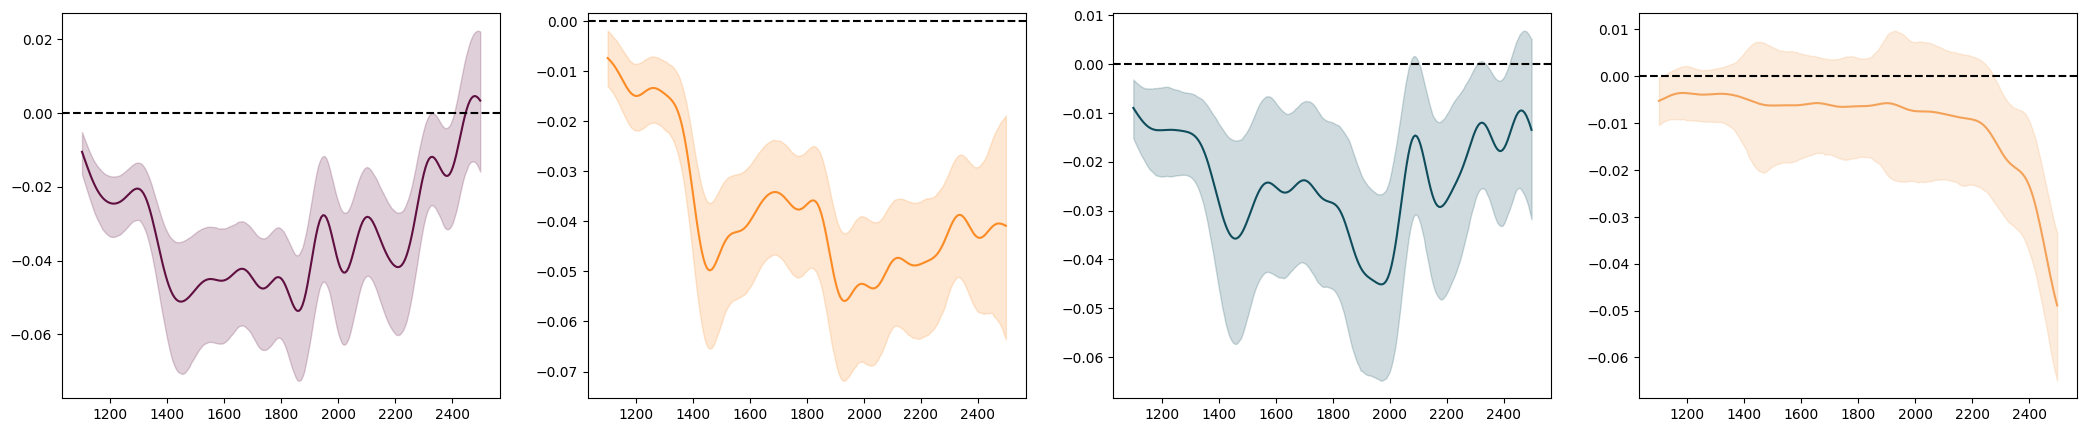

In [24]:
fig, axs = plt.subplots(1,4, figsize=(26,5), sharey=False)
for i in range(4):
    color = bmlf.default_color_dict[list(bmlf.default_color_dict)[(2*i)%9]]
    if i == 3:
        color = bmlf.default_color_dict[list(bmlf.default_color_dict)[2*i+1]]
    bmlf.uncertain_lineplot(idata.constant_data['t1'].values,
                            bmlf.convert_chain_draw_to_sample(
                                Varimax_res_xr['B1Λ1']
                            ).sel(latent_factor_idx = i).values.T,
                            ax=axs[i],
                            color=color
                           )
    axs[i].axhline(0.0, linestyle='--', c='k')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

Text(0.5, 1.0, 'Mean Latent Factor $\\boldsymbol{B}^{(2)}\\boldsymbol{\\Lambda}^{(2)}$')

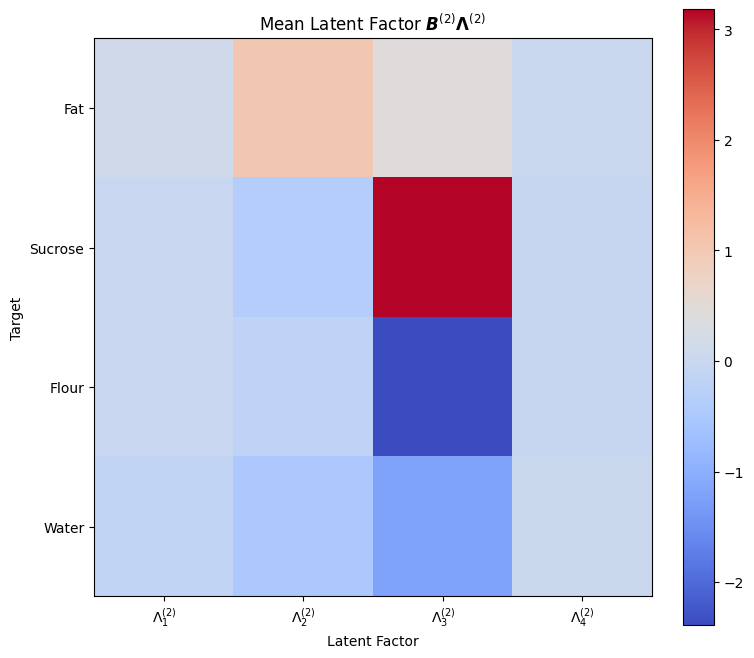

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
img = ax.imshow( Varimax_res_xr['B2Λ2'].mean('chain').mean('draw')[:,:].values , cmap = 'coolwarm')
plt.colorbar(img, ax=ax, fraction=0.05)
ax.set_xlabel('Latent Factor')
ax.set_ylabel('Target')
ax.set_xticks(np.arange(4), [r'$\Lambda_'+str(i+1)+r'^{(2)}$' for i in range(4)])
ax.set_yticks(np.arange(4), features)
ax.set_title(r'Mean Latent Factor $\boldsymbol{B}^{(2)}\boldsymbol{\Lambda}^{(2)}$')

## Compute Predictions for the Calibration Set

In [26]:
preds = bmlf.sample_conditional_predictive(idata, X_test = idata.constant_data['X'].values,
                                           rng_seed=rng.integers(1000000),
                                           Y1_test=idata.observed_data['y1'].values, required='predictive estimate')

In [27]:
bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values.shape

(2000, 40, 4)

X is within range 76 times out of 160. Which means 47.5% of the time.


Text(0.5, 1.0, 'Credibility Estimation Intervals per Sample')

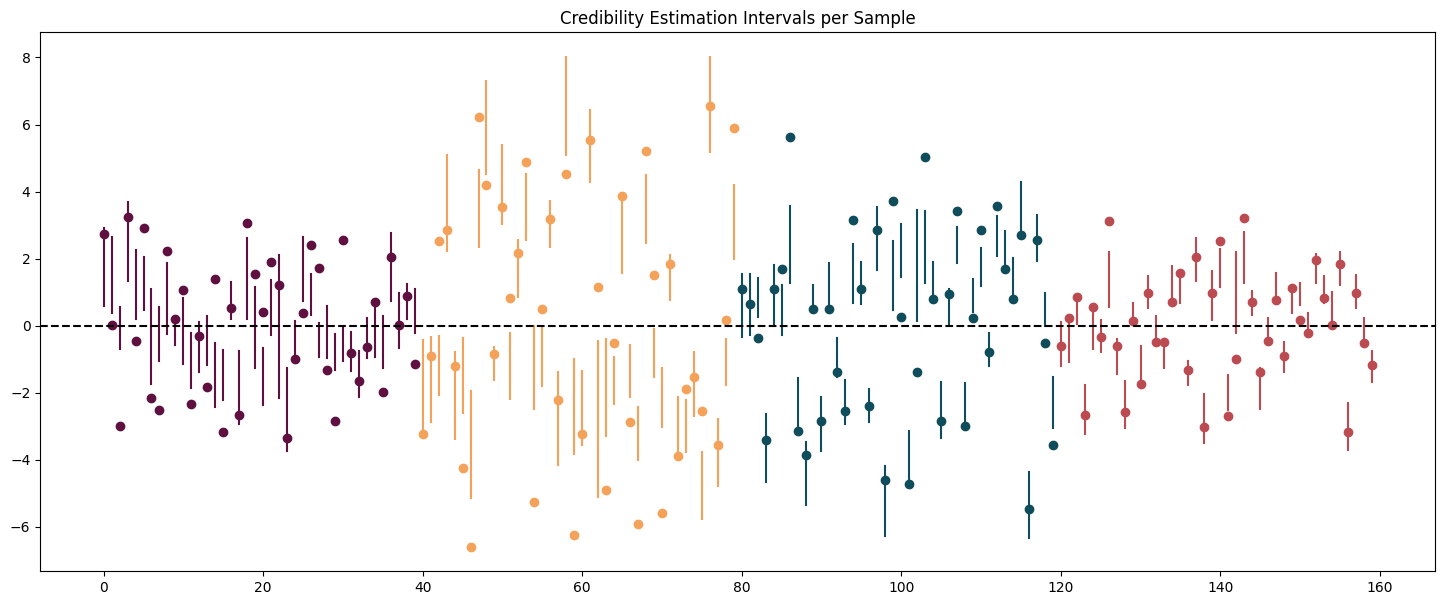

In [28]:
fig, axs = plt.subplots(1,1, figsize=(18,7))
bmlf.plot_with_credibility_intervals( Y2.T, bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values )
axs.set_title('Credibility Estimation Intervals per Sample')

In [29]:
np.std(Y2)

2.691286062809935

In [30]:
print( 'RMSE = ' + str(np.sqrt( np.square( preds.mean('chain').mean('draw').values - Y2 ).mean() )) )

RMSE = 1.4202412850628687


In [31]:
print( 'R^2 = ' + str(1 - (np.square( preds.mean('chain').mean('draw').values - Y2 ).mean())/np.var(Y2)) )

R^2 = 0.7215132471415595


In [32]:
try:
    preds = bmlf.sample_conditional_predictive(idata, X_test = idata.constant_data['X'].values,
                                               rng_seed=rng.integers(1000000),
                                               Y1_test=idata.observed_data['y1'].values, required='predictive')
except:
    # enter in this case if Sigma22 is too close to not being positive definite
    from copy import deepcopy
    idata2 = deepcopy( idata )
    idata2.posterior['Sigma_22'] += xr.DataArray(1e-4*np.eye(idata2.posterior['Sigma_22'].sizes['Sigma_22_dim_0']), dims=['Sigma_22_dim_0','Sigma_22_dim_1'])
    idata2.posterior['Sigma_22']
    preds = bmlf.sample_conditional_predictive(idata2, X_test = idata.constant_data['X'].values,
                                               rng_seed=rng.integers(1000000),
                                               Y1_test=idata.observed_data['y1'].values, required='predictive')
    del idata2

In [33]:
bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values.shape

(2000, 40, 4)

X is within range 152 times out of 160. Which means 95.0% of the time.


Text(0.5, 1.0, 'Credibility Prediction Intervals per Sample')

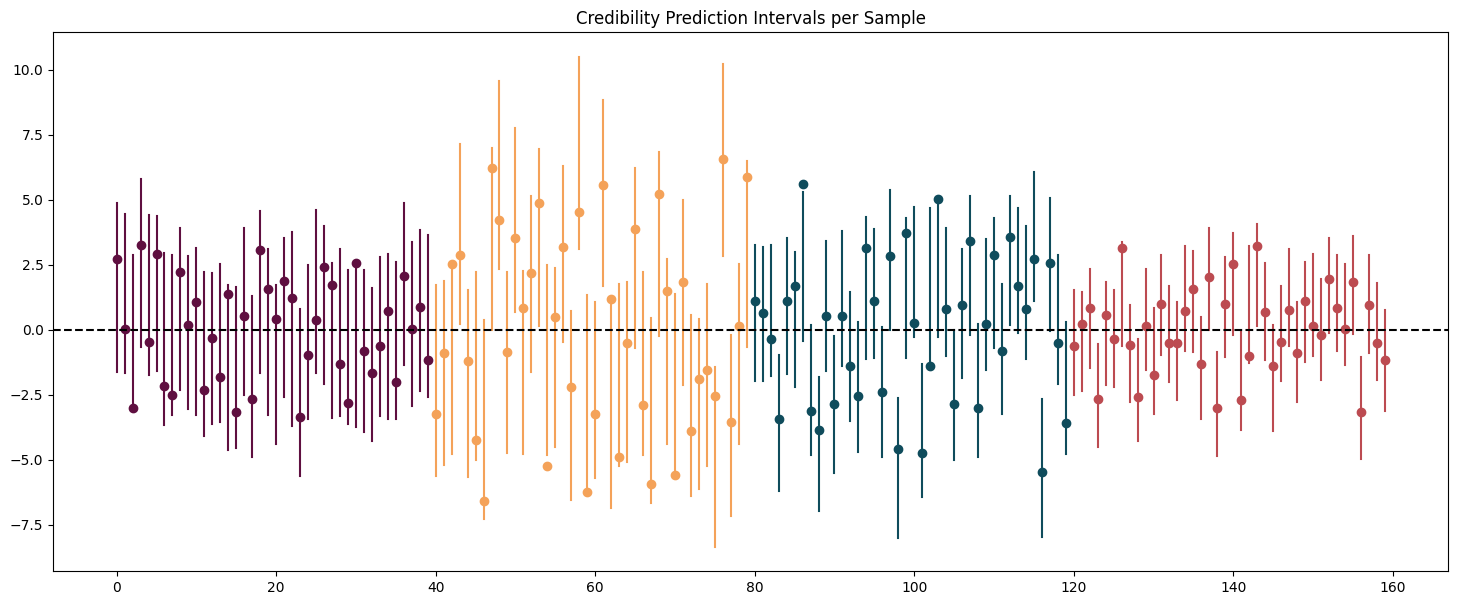

In [34]:
fig, axs = plt.subplots(1,1, figsize=(18,7))
bmlf.plot_with_credibility_intervals( Y2.T, bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values )
axs.set_title('Credibility Prediction Intervals per Sample')

## Compute Projections on the Latent Space of the Test Set (using both target and spectrum)

In [35]:
# Was already computed previously
# η_test_xr = \
# bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr,
#                                           X_test=np.zeros((1, Y2_test.shape[1])),
#                                           Y1_test = Y1_test,
#                                           Y2_test = Y2_test
#                                          )

Text(0, 0.5, '$\\eta_3$')

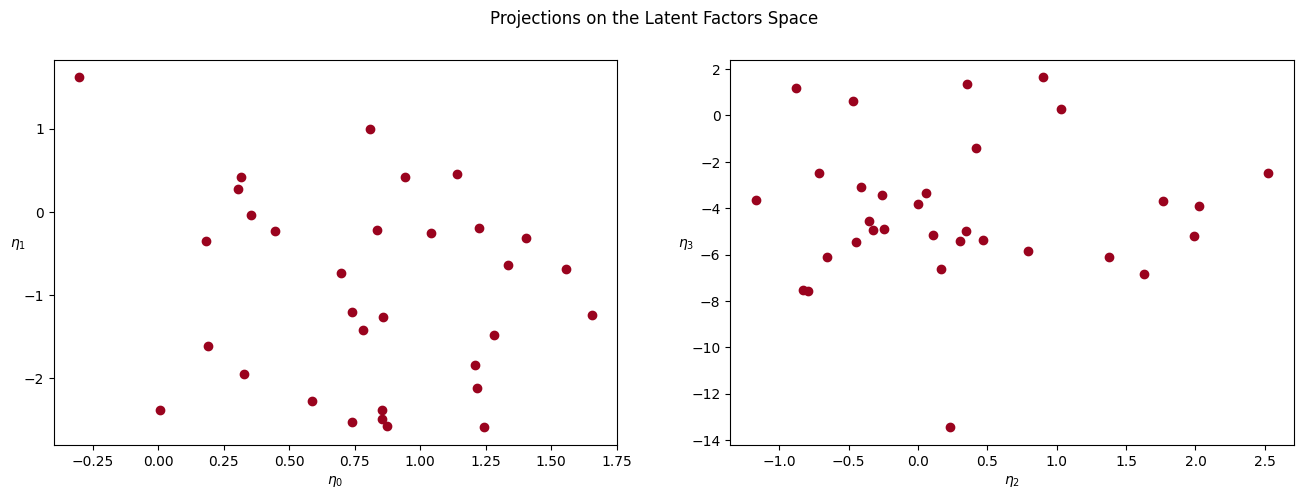

In [36]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].scatter(η_test_xr.mean('chain').mean('draw').values.T[:,0],
              η_test_xr.mean('chain').mean('draw').values.T[:,1], c=bmlf.default_color_dict['Carmine'])
ax[1].scatter(η_test_xr.mean('chain').mean('draw').values.T[:,2],
              η_test_xr.mean('chain').mean('draw').values.T[:,3], c=bmlf.default_color_dict['Carmine'])

fig.suptitle(r'Projections on the Latent Factors Space')
ax[0].set_xlabel(r'$\eta_0$')
ax[0].set_ylabel(r'$\eta_1$', rotation=0)
ax[1].set_xlabel(r'$\eta_2$')
ax[1].set_ylabel(r'$\eta_3$', rotation=0)

## Compute Projections on the Latent Space of the Test Set (using only spectrum)

In [37]:
η_test_spectrum_xr = \
bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr,
                                          X_test=np.zeros((1, Y2_test.shape[1])),
                                          Y1_test = Y1_test,
                                         )

Text(0, 0.5, '$\\eta_3$')

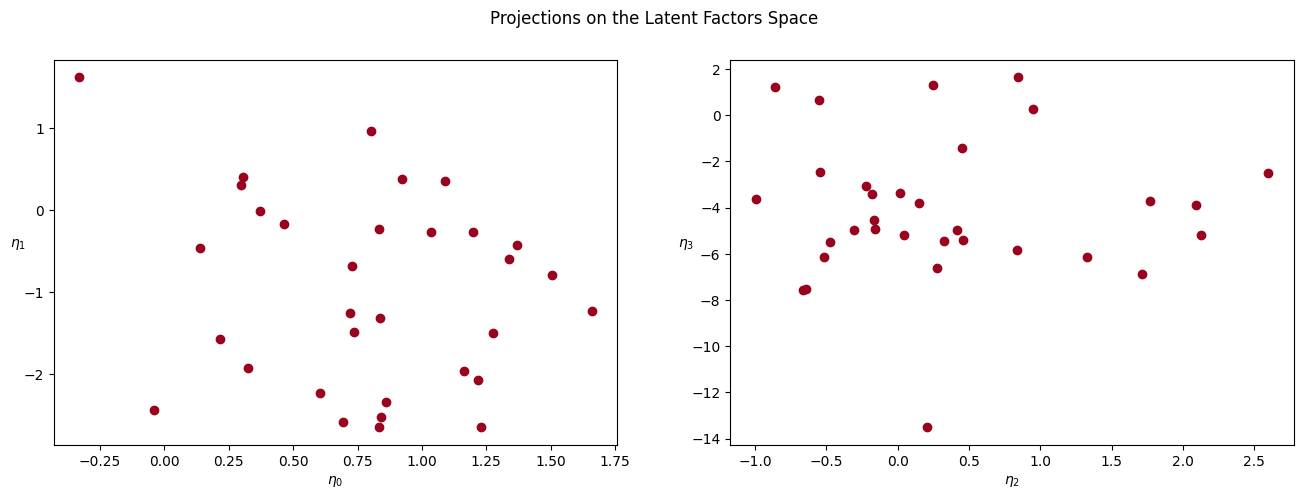

In [38]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].scatter(η_test_spectrum_xr.mean('chain').mean('draw').values.T[:,0],
              η_test_spectrum_xr.mean('chain').mean('draw').values.T[:,1], c=bmlf.default_color_dict['Carmine'])
ax[1].scatter(η_test_spectrum_xr.mean('chain').mean('draw').values.T[:,2],
              η_test_spectrum_xr.mean('chain').mean('draw').values.T[:,3], c=bmlf.default_color_dict['Carmine'])

fig.suptitle(r'Projections on the Latent Factors Space')
ax[0].set_xlabel(r'$\eta_0$')
ax[0].set_ylabel(r'$\eta_1$', rotation=0)
ax[1].set_xlabel(r'$\eta_2$')
ax[1].set_ylabel(r'$\eta_3$', rotation=0)

## Compute Predictions for the Test Set

In [39]:
preds = bmlf.sample_conditional_predictive(idata, X_test = np.zeros((1,Y1_test.shape[1])),
                                           rng_seed=rng.integers(1000000),
                                           Y1_test=Y1_test, required='predictive estimate')

In [40]:
bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values.shape

(2000, 32, 4)

X is within range 104 times out of 128. Which means 81.25% of the time.


Text(0.5, 1.0, 'Credibility Estimation Intervals per Sample')

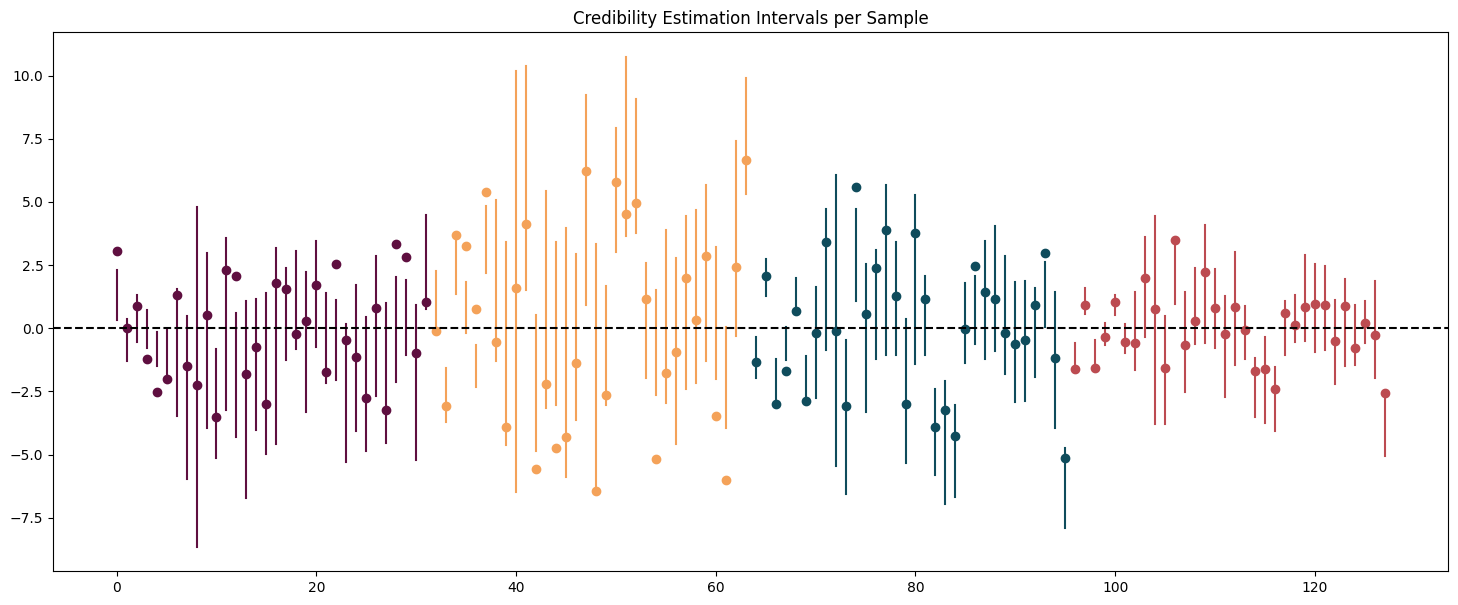

In [41]:
fig, axs = plt.subplots(1,1, figsize=(18,7))
bmlf.plot_with_credibility_intervals( Y2_test.T, bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values )
axs.set_title('Credibility Estimation Intervals per Sample')

In [42]:
np.std(Y2_test)

2.629146943058406

In [43]:
print( 'RMSE = ' + str(np.sqrt( np.square( preds.mean('chain').mean('draw').values - Y2_test ).mean() )) )

RMSE = 1.6247048803615713


In [44]:
print( 'R^2 = ' + str(1 - (np.square( preds.mean('chain').mean('draw').values - Y2_test ).mean())/np.var(Y2_test)) )

R^2 = 0.6181267379794877


In [45]:
try:
    preds = bmlf.sample_conditional_predictive(idata, X_test = np.zeros((1,Y1_test.shape[1])),
                                               rng_seed=rng.integers(1000000),
                                               Y1_test=Y1_test, required='predictive')
except:
    # enter in this case if Sigma22 is too close to not being positive definite
    from copy import deepcopy
    idata2 = deepcopy( idata )
    idata2.posterior['Sigma_22'] += xr.DataArray(1e-4*np.eye(idata2.posterior['Sigma_22'].sizes['Sigma_22_dim_0']), dims=['Sigma_22_dim_0','Sigma_22_dim_1'])
    idata2.posterior['Sigma_22']
    preds = bmlf.sample_conditional_predictive(idata2, X_test = np.zeros((1,Y1_test.shape[1])),
                                               rng_seed=rng.integers(1000000),
                                               Y1_test=Y1_test, required='predictive')
    del idata2

In [46]:
bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values.shape

(2000, 32, 4)

X is within range 124 times out of 128. Which means 96.875% of the time.


Text(0.5, 1.0, 'Credibility Prediction Intervals per Sample')

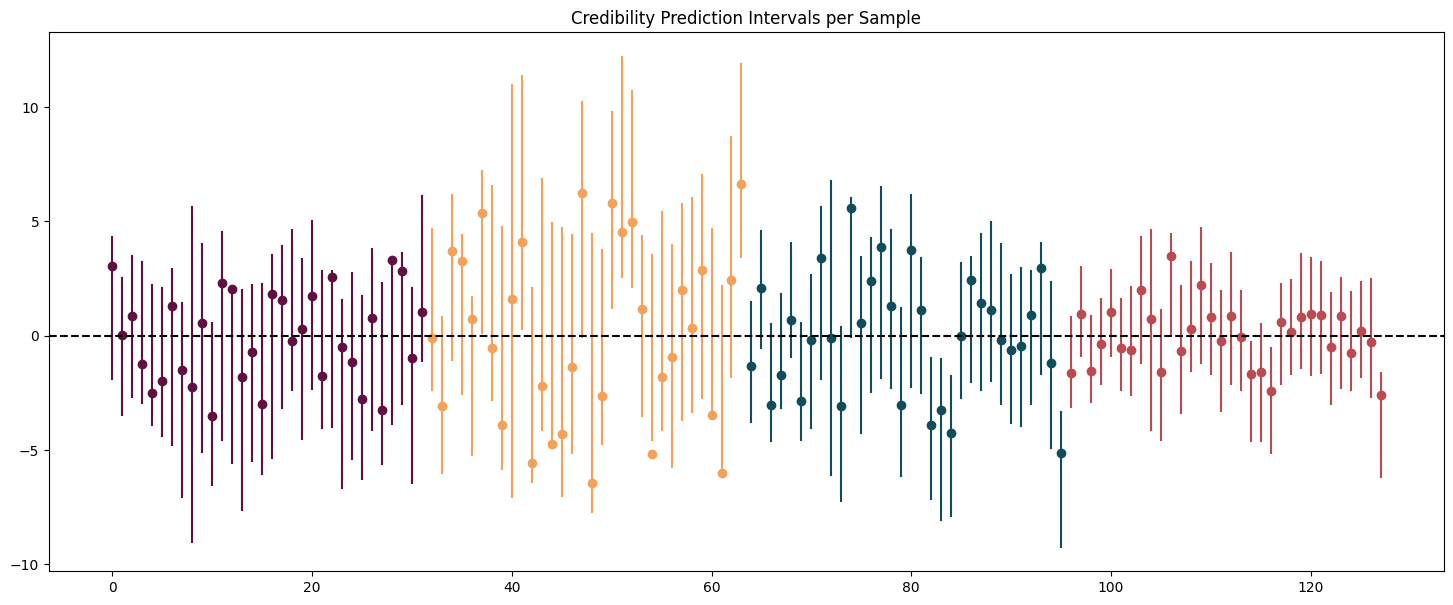

In [47]:
fig, axs = plt.subplots(1,1, figsize=(18,7))
bmlf.plot_with_credibility_intervals( Y2_test.T, bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values )
axs.set_title('Credibility Prediction Intervals per Sample')